# Computational Data Mining | Project 2

## Importing Required Libraries

In [36]:
from time import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer, fetch_california_housing, load_iris
from sklearn.decomposition import PCA, TruncatedSVD, FastICA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, silhouette_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from dataclasses import dataclass

## Classes and Functions

In [ ]:
@dataclass
class DataSet:
    name: str
    features: pd.DataFrame
    target: pd.Series
    extracted_features: pd.DataFrame = None
    selected_features: pd.DataFrame = None
    
    def get_all_samples(self) -> pd.DataFrame:
        all_data = self.features.copy()
        all_data['target'] = self.target
        return all_data
    
    def get_features(self) -> dict[str, pd.DataFrame]:
        return {
            'Orginal Features': self.features,
            'Extracted Features': self.extracted_features,
            'Selected Features': self.selected_features
        }
        
    def get_train_test_inx(self, random_state: int=42) -> tuple:
        idx_train, idx_test = train_test_split(
            np.arange(len(self.target)),
            test_size=0.2,
            random_state=random_state
        )
        return idx_train, idx_test
    
    def get_train_test_target(self) -> tuple[pd.Series, pd.Series]:
        idx_train, idx_test = self.get_train_test_inx()
        y_train = self.target.iloc[idx_train]
        y_test = self.target.iloc[idx_test]
        return y_train, y_test
    
    def __str__(self) -> str:
        return (
            f"Dataset: {self.name}\n"
            f"Features: {self.features.shape[1]} columns, {self.features.shape[0]} samples\n"
            f"Target: {self.target.name} ({len(self.target.unique())} unique values)\n"
            f"Data types: {dict(self.features.dtypes.value_counts())}"
        )


def print_explained_variance_ratio(dataset_name, explained_variance_ratio):
    print(
        f'Explained Variance Ratio for {dataset_name}',
        '\n'.join([f'component {i}: {x}' for i, x in enumerate(explained_variance_ratio, start=1)]),
        sep='\n'
    )
    

def show_explained_variance_ratio(dataset_name, explained_variance_ratio):
    plt.plot(range(1, len(explained_variance_ratio)+1), explained_variance_ratio)
    plt.title(f'{dataset_name}')
    plt.xlabel('Components')
    plt.ylabel('Explained Variance Ratio')
    plt.show()
    

def show_cumulative_explained_variance(dataset_name, explained_variance_ratio):
    plt.plot(range(1, len(explained_variance_ratio)+1), explained_variance_ratio.cumsum())
    plt.title(f'{dataset_name}')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.show()


## 1. Dataset Loading and Overview

In [4]:
cancer = load_breast_cancer()
housing = pd.read_csv('Boston-house-price-data.csv')
iris = load_iris()

cancer_dataset = DataSet(
    name='Wisconsin Breast Cancer',
    features=pd.DataFrame(cancer.data, columns=cancer.feature_names),
    target=pd.Series(cancer.target, name='target')
)

housing_dataset = DataSet(
    name='Boston Housing',
    features=housing.drop('MEDV', axis=1),
    target=housing['MEDV']
)

iris_dataset = DataSet(
    name='UCI Iris',
    features=pd.DataFrame(iris.data, columns=iris.feature_names),
    target=pd.Series(iris.target, name='target')
)

datasets = [cancer_dataset, housing_dataset, iris_dataset]

In [5]:
for dataset in datasets:
    print(dataset)
    display(dataset.get_all_samples().head())


Dataset: Wisconsin Breast Cancer
Features: 30 columns, 569 samples
Target: target (2 unique values)
Data types: {dtype('float64'): np.int64(30)}


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


Dataset: Boston Housing
Features: 13 columns, 506 samples
Target: MEDV (229 unique values)
Data types: {dtype('float64'): np.int64(11), dtype('int64'): np.int64(2)}


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


Dataset: UCI Iris
Features: 4 columns, 150 samples
Target: target (3 unique values)
Data types: {dtype('float64'): np.int64(4)}


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


## 2. Initial Data Analysis and Correlation Heatmap

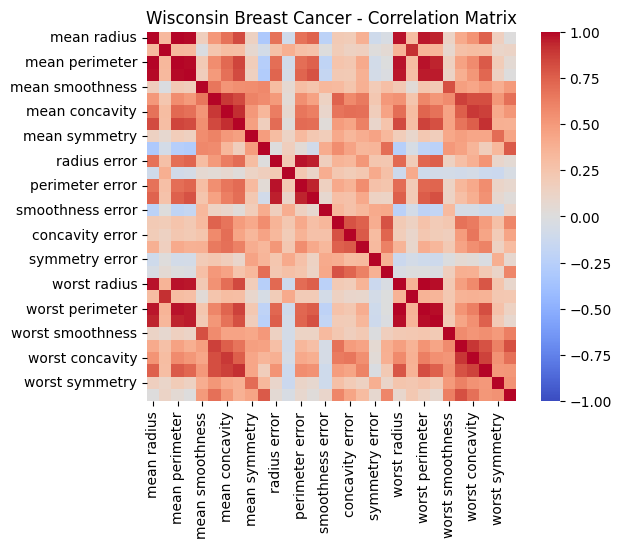

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
mean radius,1.000000,0.323782,0.997855,0.987357,0.170581,0.506124,0.676764,0.822529,0.147741,-0.311631,...,0.969539,0.297008,0.965137,0.941082,0.119616,0.413463,0.526911,0.744214,0.163953,0.007066
mean texture,0.323782,1.000000,0.329533,0.321086,-0.023389,0.236702,0.302418,0.293464,0.071401,-0.076437,...,0.352573,0.912045,0.358040,0.343546,0.077503,0.277830,0.301025,0.295316,0.105008,0.119205
mean perimeter,0.997855,0.329533,1.000000,0.986507,0.207278,0.556936,0.716136,0.850977,0.183027,-0.261477,...,0.969476,0.303038,0.970387,0.941550,0.150549,0.455774,0.563879,0.771241,0.189115,0.051019
mean area,0.987357,0.321086,0.986507,1.000000,0.177028,0.498502,0.685983,0.823269,0.151293,-0.283110,...,0.962746,0.287489,0.959120,0.959213,0.123523,0.390410,0.512606,0.722017,0.143570,0.003738
mean smoothness,0.170581,-0.023389,0.207278,0.177028,1.000000,0.659123,0.521984,0.553695,0.557775,0.584792,...,0.213120,0.036072,0.238853,0.206718,0.805324,0.472468,0.434926,0.503053,0.394309,0.499316
mean compactness,0.506124,0.236702,0.556936,0.498502,0.659123,1.000000,0.883121,0.831135,0.602641,0.565369,...,0.535315,0.248133,0.590210,0.509604,0.565541,0.865809,0.816275,0.815573,0.510223,0.687382
mean concavity,0.676764,0.302418,0.716136,0.685983,0.521984,0.883121,1.000000,0.921391,0.500667,0.336783,...,0.688236,0.299879,0.729565,0.675987,0.448822,0.754968,0.884103,0.861323,0.409464,0.514930
mean concave points,0.822529,0.293464,0.850977,0.823269,0.553695,0.831135,0.921391,1.000000,0.462497,0.166917,...,0.830318,0.292752,0.855923,0.809630,0.452753,0.667454,0.752399,0.910155,0.375744,0.368661
mean symmetry,0.147741,0.071401,0.183027,0.151293,0.557775,0.602641,0.500667,0.462497,1.000000,0.479921,...,0.185728,0.090651,0.219169,0.177193,0.426675,0.473200,0.433721,0.430297,0.699826,0.438413
mean fractal dimension,-0.311631,-0.076437,-0.261477,-0.283110,0.584792,0.565369,0.336783,0.166917,0.479921,1.000000,...,-0.253691,-0.051269,-0.205151,-0.231854,0.504942,0.458798,0.346234,0.175325,0.334019,0.767297


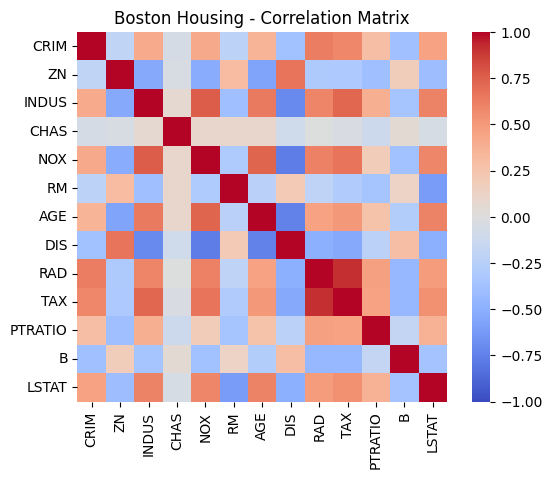

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
CRIM,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621
ZN,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995
INDUS,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800
CHAS,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929
NOX,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879
RM,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808
AGE,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339
DIS,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996
RAD,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676
TAX,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993


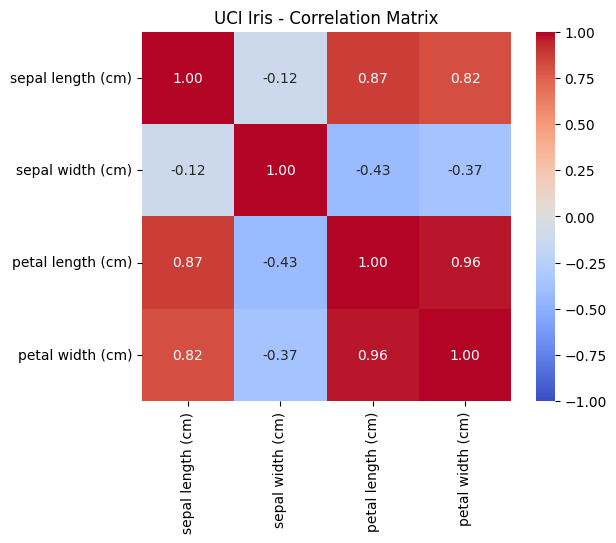

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
sepal length (cm),1.000000,-0.117570,0.871754,0.817941
sepal width (cm),-0.117570,1.000000,-0.428440,-0.366126
petal length (cm),0.871754,-0.428440,1.000000,0.962865
petal width (cm),0.817941,-0.366126,0.962865,1.000000


In [6]:
def calculate_save_draw_corr_matrix(df: pd.DataFrame, name: str):
    title = f'{name} - Correlation Matrix'
    corr = df.corr()
    corr.to_excel(f'{title}.xlsx')
    sns.heatmap(
        corr,
        cmap='coolwarm',
        vmin=-1,
        center=0,
        vmax=1,
        square=True,
        annot=(corr.shape[0] < 10),
        fmt='.2f'
    )
    plt.title(title)
    plt.show()
    display(corr)


for dataset in datasets:
    calculate_save_draw_corr_matrix(dataset.features, dataset.name)


## 3. Feature Extraction

### PCA

Explained Variance Ratio for Wisconsin Breast Cancer
component 1: 0.4427202560752637
component 2: 0.18971182044033086
component 3: 0.09393163257431386
component 4: 0.06602134915470141
component 5: 0.05495768492346264
component 6: 0.040245220398833464
component 7: 0.02250733712982506
component 8: 0.015887238000213275
component 9: 0.01389649374559109
component 10: 0.011689781894131487


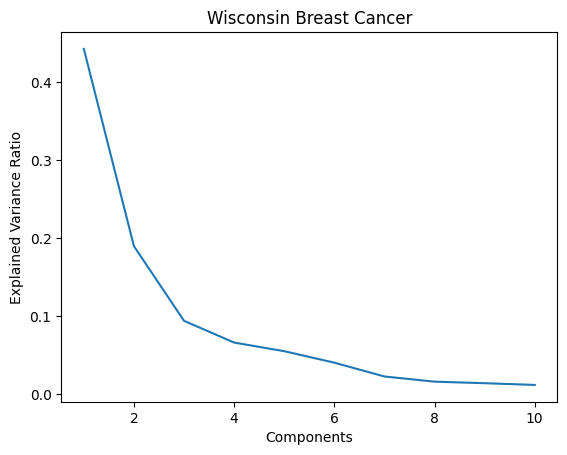

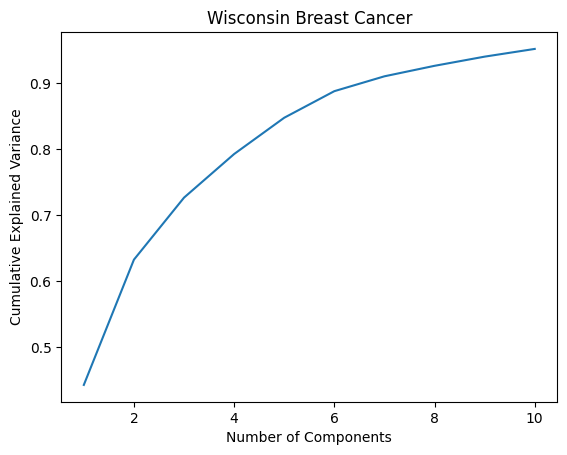

Explained Variance Ratio for Boston Housing
component 1: 0.47129606357274634
component 2: 0.11025193247588003
component 3: 0.09558589792622946
component 4: 0.06596731600836164
component 5: 0.06421661052137369
component 6: 0.0505697827229128
component 7: 0.04118123739654428
component 8: 0.030469024189856638
component 9: 0.021303333054001693


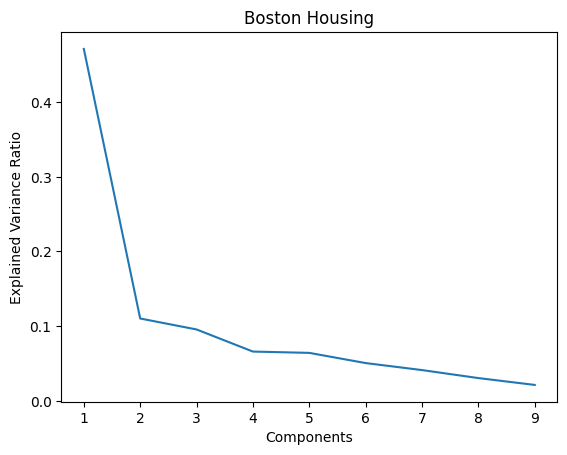

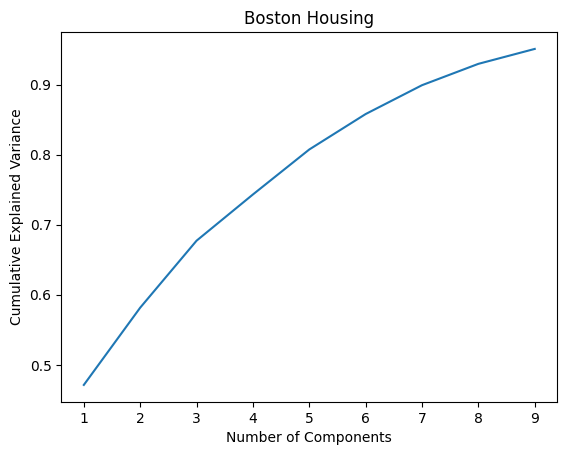

Explained Variance Ratio for UCI Iris
component 1: 0.7296244541329989
component 2: 0.22850761786701768


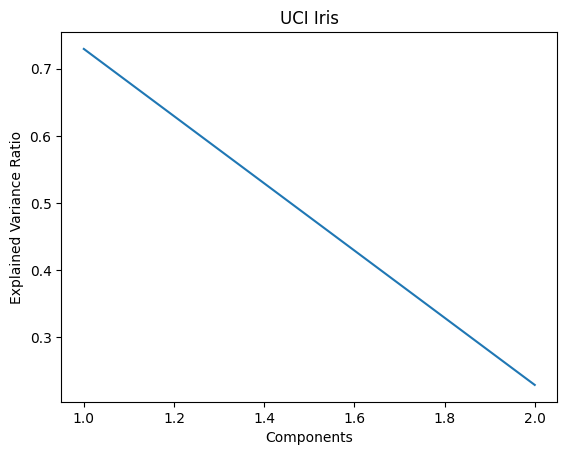

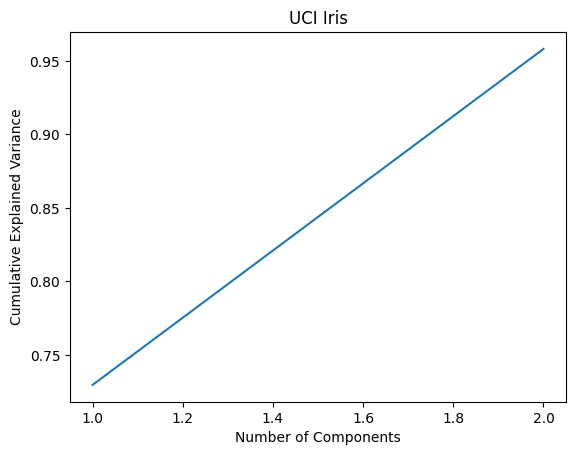

In [ ]:
explained_variance_ratio_threshold = 0.95

for dataset in datasets:
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(dataset.features)
    pca = PCA(n_components=explained_variance_ratio_threshold)
    pca_features = pca.fit_transform(scaled_features)
    pca_columns = [f"PC{i+1}" for i in range(pca_features.shape[1])]
    dataset.extracted_features = pd.DataFrame(pca_features, columns=pca_columns, index=dataset.features.index)

    print_explained_variance_ratio(dataset.name, pca.explained_variance_ratio_)
    show_explained_variance_ratio(dataset.name, pca.explained_variance_ratio_)
    show_cumulative_explained_variance(dataset.name, pca.explained_variance_ratio_)


### SVD

Explained Variance Ratio for Wisconsin Breast Cancer
component 1: 0.4427202560752632
component 2: 0.1897118204403307
component 3: 0.09393163257431383
component 4: 0.06602134915470148
component 5: 0.054957684923462695
component 6: 0.04024522039883347
component 7: 0.022507337129825052
component 8: 0.015887238000213275
component 9: 0.0138964937455911
component 10: 0.011689781894131487
component 11: 0.009797189875980179
component 12: 0.008705379007378836
component 13: 0.008045249871967303
component 14: 0.005233657454926357
component 15: 0.0031378321676274034
component 16: 0.002662093365152314
component 17: 0.001979967925324272
component 18: 0.0017539594502263586
component 19: 0.0016492530592251632
component 20: 0.0010386467483387057
component 21: 0.0009990964637002523
component 22: 0.0009146467510543473
component 23: 0.0008113612588991053
component 24: 0.0006018335666716709
component 25: 0.000516042379165188
component 26: 0.0002725879954775007
component 27: 0.0002300154625059646
component 

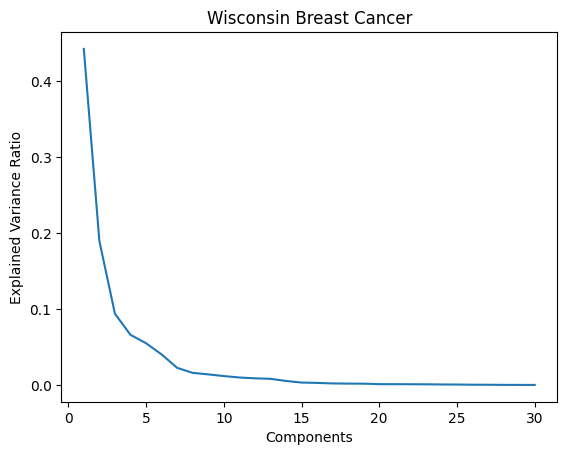

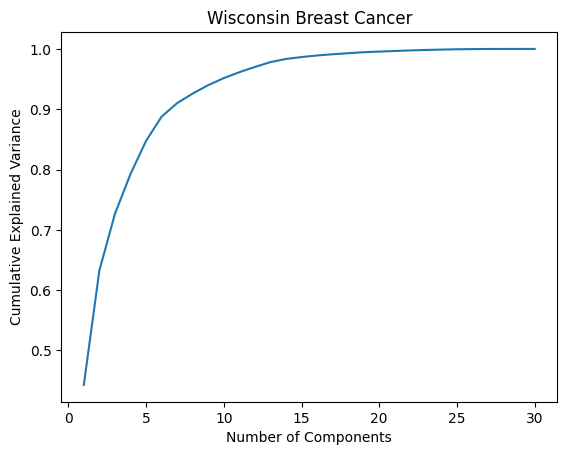

Explained Variance Ratio for Boston Housing
component 1: 0.47129606357274684
component 2: 0.11025193247588018
component 3: 0.09558589792622953
component 4: 0.06596731600836157
component 5: 0.06421661052137359
component 6: 0.05056978272291269
component 7: 0.0411812373965444
component 8: 0.03046902418985661
component 9: 0.021303333054001745
component 10: 0.01694137114842006
component 11: 0.014308797464566047
component 12: 0.013023305792840216
component 13: 0.0048853277262669356
Number of selected components: 8


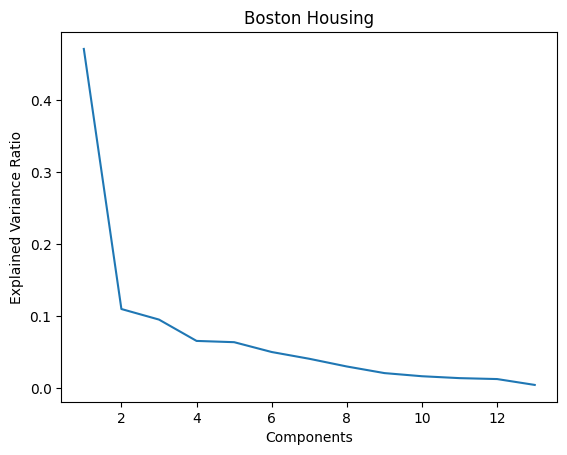

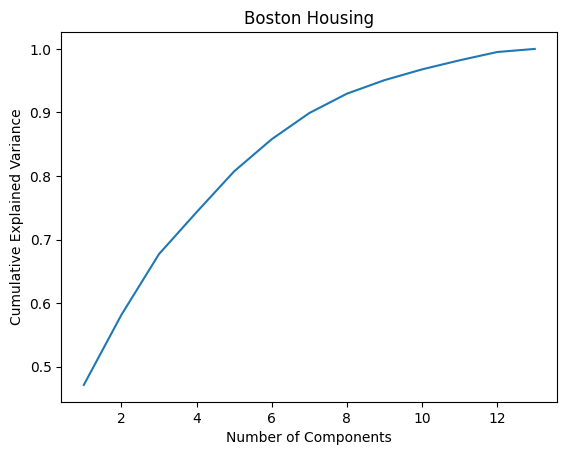

Explained Variance Ratio for UCI Iris
component 1: 0.7296244541329989
component 2: 0.22850761786701765
component 3: 0.03668921889282883
component 4: 0.005178709107154803
Number of selected components: 1


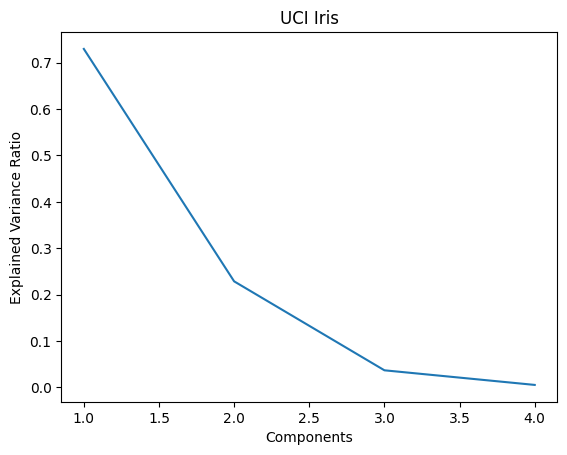

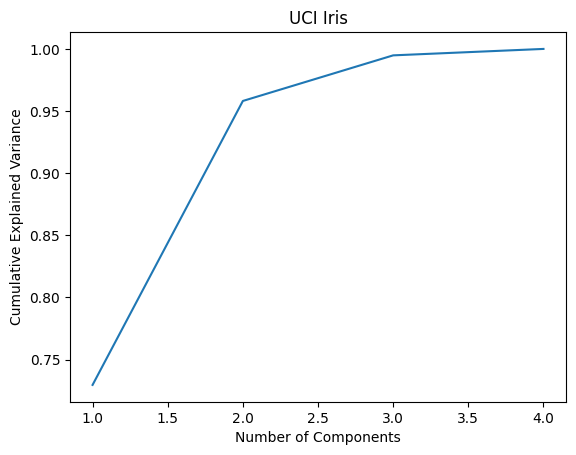

In [33]:
explained_variance_ratio_threshold = 0.95

for dataset in datasets:
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(dataset.features)
    
    svd = TruncatedSVD(n_components=dataset.features.shape[1], random_state=42)
    svd_features = svd.fit_transform(scaled_features)
    
    cumulative_variance = svd.explained_variance_ratio_.cumsum()
    

    
    n_components = len(cumulative_variance[cumulative_variance <= explained_variance_ratio_threshold])
    
    svd_final = TruncatedSVD(n_components=n_components)
    svd_features_final = svd_final.fit_transform(scaled_features)
    
    print_explained_variance_ratio(dataset.name, svd.explained_variance_ratio_)
    print(f'Number of selected components: {n_components}')
    show_explained_variance_ratio(dataset.name, svd.explained_variance_ratio_)
    show_cumulative_explained_variance(dataset.name, svd.explained_variance_ratio_)


### ICA

In [27]:
for dataset in datasets:
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(dataset.features)
    ica = FastICA(n_components=dataset.features.shape[1], random_state=42, max_iter=1000)
    ica_features = ica.fit_transform(scaled_features)
    ica_columns = [f"ICA{i+1}" for i in range(ica_features.shape[1])]
    print(f'ICA matrix for {dataset.name}')
    display(pd.DataFrame(ica_features, columns=ica_columns, index=dataset.features.index))
    

ICA matrix for Wisconsin Breast Cancer


,ICA1,ICA2,ICA3,ICA4,ICA5,ICA6,ICA7,ICA8,ICA9,ICA10,...,ICA21,ICA22,ICA23,ICA24,ICA25,ICA26,ICA27,ICA28,ICA29,ICA30
0,-0.345062,-0.520724,-1.201357,-0.100342,-2.995672,-2.603593,0.425937,-0.009123,-2.567425,-1.361637,...,0.000335,0.453734,-2.164967,3.040325,-1.019748,4.903976,1.481213,1.033210,-0.739680,-0.057352
1,0.544313,0.200128,-1.516973,0.426968,-0.102088,-0.444059,-2.740405,-0.523039,1.919033,1.935182,...,0.020342,-0.146597,2.135538,-2.632897,1.187703,-0.084246,1.265278,0.931143,-0.213374,-0.735148
2,1.408106,-0.132473,-0.544766,-1.099835,0.374481,-0.243757,0.929760,0.985217,0.513553,-1.827022,...,0.089957,0.109596,1.440818,-1.376166,-0.050665,-0.896425,0.377144,0.336579,0.092986,-0.293183
3,1.849944,0.519734,0.586899,0.748025,-4.179305,-1.585767,1.686674,0.249041,2.603257,0.048136,...,0.607154,0.637696,-0.053311,-1.152891,-0.147227,-0.033193,2.617217,-1.517439,-1.346622,-0.218106
4,-2.519518,-0.633011,-0.884891,-0.669803,1.392739,-0.162806,-1.073917,-0.215080,0.426146,0.000067,...,-0.643332,-0.939801,1.559785,0.244236,0.428734,1.515092,0.190443,0.510423,1.966538,-0.398767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,0.885700,-0.718679,-1.032319,-3.616695,-0.513483,-0.578751,-0.320014,0.249519,0.537829,-1.874499,...,-0.179211,-0.720943,1.891994,-1.108594,-0.314884,-0.691404,0.856445,-0.137716,1.395183,-0.606404
565,1.092265,0.609275,0.189832,-1.127325,-0.059829,1.161069,0.038167,-0.446246,-0.701158,-0.556628,...,0.130754,0.638049,1.471840,0.145029,-0.583669,-0.889962,0.535697,1.282958,-0.881169,-1.259858
566,0.213196,0.242105,-0.522976,-0.630676,0.526558,0.389979,0.064507,0.176771,-0.096701,0.800614,...,0.036878,0.813758,0.056474,0.531948,-0.235940,-2.586321,0.091477,-0.176734,0.729413,-0.668451
567,-0.037448,-0.793384,0.118270,0.571451,-2.942785,-1.856918,4.277514,-0.539880,0.316972,-0.242609,...,-0.396985,-0.086478,1.203976,4.043107,-0.235467,-0.444828,1.720289,2.247912,-0.268151,-0.104930


ICA matrix for Boston Housing


,ICA1,ICA2,ICA3,ICA4,ICA5,ICA6,ICA7,ICA8,ICA9,ICA10,ICA11,ICA12,ICA13
0,-0.059658,0.878679,-0.075903,0.506086,-1.740989,0.039428,-1.073684,0.184572,-0.893505,0.746570,-0.229686,-0.416407,0.851523
1,-0.027018,0.257961,0.675498,0.387962,0.174520,-0.343364,0.294157,-1.000471,-0.457576,0.657121,-1.333920,-0.326192,0.429421
2,-0.157716,-0.075761,0.626071,0.261454,0.123571,-1.538306,0.261556,-0.869435,-0.834856,0.516372,-0.315863,-0.370619,0.291101
3,-0.143737,-1.319604,0.552989,0.218435,-0.703875,-1.271500,0.098008,-0.993676,-0.765703,0.853812,-0.210949,-0.367053,0.472428
4,-0.106422,-1.161004,0.373752,0.201720,-0.642397,-1.622729,0.228940,-1.027946,-0.295126,0.765010,-0.628662,-0.355425,0.512723
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,-0.091941,-0.584411,-1.233252,0.154293,1.064977,-0.939677,-0.511491,0.200546,-0.338736,1.840303,0.819696,-0.296204,-0.624221
502,-0.085556,-0.404841,-1.185326,0.289685,1.096394,0.041750,-0.513227,0.187249,-0.878511,2.062107,0.456604,-0.279676,-0.490262
503,-0.200369,-0.165717,-1.650507,0.188805,1.252989,-1.168940,-0.173872,0.183937,-1.448437,1.962207,-0.162717,-0.297244,-0.375375
504,-0.187672,-0.262501,-1.492291,0.176981,1.204071,-0.956161,-0.262872,0.119202,-1.351927,1.936738,-0.211725,-0.298510,-0.444880


ICA matrix for UCI Iris


,ICA1,ICA2,ICA3,ICA4
0,0.018627,0.261872,1.393039,0.373243
1,-0.083998,0.378051,1.329251,-0.975374
2,-0.160859,-0.362082,1.347871,-0.348672
3,0.314605,-0.882145,1.205067,-0.373493
4,0.097900,-0.197311,1.373318,0.737673
...,...,...,...,...
145,-2.595109,1.252710,-0.839837,-0.339973
146,-1.046296,0.713533,-0.761464,-1.371148
147,-0.982440,0.338150,-0.831910,0.085168
148,-1.765245,-1.251875,-1.058049,1.389707


## 4. Feature Selection

### SelectKBest

In [34]:
for dataset in datasets:
    selector = SelectKBest(score_func=f_classif, k=int(0.5 * dataset.features.shape[1]))
    kbest_features = selector.fit_transform(dataset.features, dataset.target)
    selected_columns = dataset.features.columns[selector.get_support()]
    dataset.selected_features = pd.DataFrame(kbest_features, columns=selected_columns, index=dataset.features.index)

    print(f"Selected Features of {dataset.name}: {selector.get_support(indices=True)}")


Selected Features of Wisconsin Breast Cancer: [ 0  2  3  5  6  7 10 12 13 20 22 23 25 26 27]
Selected Features of Boston Housing: [ 0  4  5  6  9 12]
Selected Features of UCI Iris: [2 3]


### RFE

In [38]:
for dataset in datasets:
    selector_rfe = RFE(
        estimator=LinearRegression(), 
        n_features_to_select=int(0.5 * dataset.features.shape[1])
    )
    rfe_features = selector_rfe.fit_transform(dataset.features, dataset.target)

    print(f"RFE Features of {dataset.name}: {selector_rfe.get_support(indices=True)}")


RFE Features of Wisconsin Breast Cancer: [ 4  5  7  8  9 10 14 15 16 17 24 26 27 28 29]
RFE Features of Boston Housing: [ 3  4  5  7 10 12]
RFE Features of UCI Iris: [2 3]


## 5. Model Training and Optimization Analysis

### A.

In [40]:
lr_models: list[LinearRegression] = []
sgdr_models: list[SGDRegressor] = []

idx_train, idx_test = housing_dataset.get_train_test_inx()
y_train, y_test = housing_dataset.get_train_test_target()

for name, features in housing_dataset.get_features().items():
    X_train = features.iloc[idx_train]
    X_test = features.iloc[idx_test]
    
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    lr_models.append(lr)
    y_pred_lr = lr.predict(X_test)
    print(f"LinearRegression MSE for {name}:", mean_squared_error(y_test, y_pred_lr))
    
    sgdr = SGDRegressor(max_iter=1000, tol=1e-3, random_state=42)
    sgdr.fit(X_train, y_train)
    sgdr_models.append(sgdr)
    y_pred_sgdr = sgdr.predict(X_test)
    print(f"SGDRegressor MSE for {name}:", mean_squared_error(y_test, y_pred_sgdr))


LinearRegression MSE for orginal features: 24.291119474973538
SGDRegressor MSE for orginal features: 1.5786065627805645e+28
LinearRegression MSE for extracted features: 29.510302326083103
SGDRegressor MSE for extracted features: 29.586017129077632
LinearRegression MSE for selectedfeatures: 31.833679124255344
SGDRegressor MSE for selectedfeatures: 2.568360789847399e+28


In [41]:
print('Original data coefficients:', lr_models[0].coef_, sep='\n', end='\n\n')
print('PCA data coefficients:', lr_models[1].coef_, sep='\n', end='\n\n')

print('Original coefficient mean absolute:', np.mean(np.abs(lr_models[0].coef_)))
print('PCA coefficient mean absolute:', np.mean(np.abs(lr_models[1].coef_)))

print('Original coefficient variance:', np.var(lr_models[0].coef_))
print('PCA coefficient variance:', np.var(lr_models[1].coef_))

# cross_val_score ?

# diagram ?

Original data coefficients:
[-1.13055924e-01  3.01104641e-02  4.03807204e-02  2.78443820e+00
 -1.72026334e+01  4.43883520e+00 -6.29636221e-03 -1.44786537e+00
  2.62429736e-01 -1.06467863e-02 -9.15456240e-01  1.23513347e-02
 -5.08571424e-01]

PCA data coefficients:
[-2.30745351  2.41178735  3.40890117 -1.16330553  2.60111095  0.67668617
 -0.10741838 -1.06257339  0.22408861]

Original coefficient mean absolute: 2.1363900888919507
PCA coefficient mean absolute: 1.5514805620205239
Original coefficient variance: 24.18325459944381
PCA coefficient variance: 3.3437721225494634


### B.

In [ ]:
kmeans_models: list[KMeans] = []
train_time: list[float] = []
silhouette_scores: list[float] = []

idx_train, idx_test = iris_dataset.get_train_test_inx()
y_train, y_test = iris_dataset.get_train_test_target()

for name, features in iris_dataset.get_features().items():
    X_train = features.iloc[idx_train]
    X_test = features.iloc[idx_test]
    
    start = time()
    kmeans = KMeans(n_clusters=3, random_state=42)
    labels = kmeans.fit_predict(features)
    train_time.append(time() - start)
    kmeans_models.append(kmeans)
    silhouette_scores.append(silhouette_score(features, labels))


In [ ]:
print('Original data inertia:', kmeans_models[0].inertia_)
print('PCA data inertia:',  kmeans_models[1].inertia_)

print('Original data silhouette scores:', silhouette_scores[0])
print('PCA data silhouette scores:', silhouette_scores[1])

print('Original data train time:', train_time[0])
print('PCA data train time:', train_time[1])


### C.

In [ ]:
knn_models: list[KNeighborsClassifier] = []
accuracy: list[float] = []
pred_time: list[float] = []

idx_train, idx_test = cancer_dataset.get_train_test_inx()
y_train, y_test = cancer_dataset.get_train_test_target()

for name, features in cancer_dataset.get_features().items():
    X_train = features.iloc[idx_train]
    X_test = features.iloc[idx_test]
    knn = KNeighborsClassifier()
    knn.fit(X_train, y_train)
    start = time()
    X_pred = knn.predict(X_test)
    pred_time.append(time() - start)
    accuracy.append(knn.score(X_test, y_test))


In [59]:
print(f'Original data accuracy: {accuracy[0]}')
print(f'PCA data accuracy: {accuracy[1]}')
print(f'Original data predicdt time: {pred_time[0]}')
print(f'PCA data predicdt time: {pred_time[1]}')


Original data accuracy: 0.956140350877193
PCA data accuracy: 0.956140350877193
Original data predicdt time: 0.18256855010986328
PCA data predicdt time: 0.025340795516967773


In [60]:
rf_models: list[RandomForestClassifier] = []

idx_train, idx_test = cancer_dataset.get_train_test_inx()
y_train, y_test = cancer_dataset.get_train_test_target()

for name, features in cancer_dataset.get_features().items():
    X_train = features.iloc[idx_train]
    X_test = features.iloc[idx_test]
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train, y_train)   
    print(f'Accuracy for {name}: {rf.score(X_test, y_test)}')


Accuracy for orginal features: 0.9649122807017544
Accuracy for extracted features: 0.956140350877193
Accuracy for selectedfeatures: 0.956140350877193
